# NA540 Homework 8 - Estimation of Maneuvering Dynamics

MEMORANDUM

**DATE:** 12/04/2019

**TO:** A.W.Troesch, NA 540 Instructor

**FROM:** Wenzhe Xu, NA 540 Student

**RE:** NA540 Homework 8, Estimation of maneuvering dynamics.


## Executive Summary

This homework is to establish the equations of motion for maneuvering case. A reduce-order linear model is developed and a Taylor-expansion-based nonlinear model is implemented in both Python and Javascript. The control-fixed stability is evaluated by checking the sign of `C` coefficeint (details below). Steady turning test and Zig-Zag test are simulated using Euler-Explicit numerical integrator. In the steady turning test, the linear model is not as good as the nonlinear model on estimating the turning diameter and the drift angle. In the Zig-Zag test, important performance parameters, e.g. the overshoot yaw angle, the reach, and the overshoot width of path, are estimated based on the nonlinear numerical simulation.

To better visualize and hands-on the topic, a realtime online web game is developed and hosted at: 

`https://xuwenzhe.github.io/ship-maneuvering/`.

Players can use key `A`/`D` to change the commanded rudder angle and `W`/`S` to accelerate/decelerate the commanded forward speed. The game is mainly written in Javascript and space/time scale are tuned to comfort players.  More specifically, the integrator runs every 5 ms (wall-time) and the visualization is updated every 50 ms (wall-time). The integrator uses a time step of 0.2 s (simulation-time). The ship image is plotted 7X larger of the real size. The ship coordinates are plotted on a scale of 1e4 [meter] / 800 pixel canvas. A visualization tool, [Plotly](https://plot.ly/), is used to plot the streaming data.


### Dynamic definition
To see the influence of nonlinear terms on maneuvering equations, a numerical integrator using the Euler Explicit scheme is implemented. The state-derivative function $\dot{x} = f(x, u, t)$ is rewriten in Python and generalized to include a changable mean speed velocity $U_0$. This feature is turned on in the live-game mode and is turned off in problem 3 and 4. One typo in the original code, i.e. `Nrdot = -4.38e-5` has been changed to `-43.9e-5`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def dX(x, ui):
    """
    returns the time derivates of the state vector
    
    INPUTS: 
    x = [u v r psi xpos ypos delta U0]
    u      = perturbed surge velocity [m/s]
    v      = perturbed sway velocity [m/s]
    r      = perturbed yaw velocity [rad/s]
    psi    = perturbed yaw angle [rad]
    xpos   = position in x-direction [m]
    ypos   = position in y-direction [m]
    delta  = actual rudder angle [rad]
    U0     = mean velocity [m/s]

    
    ui = [delta_c, U0c] commanded rudder angle [rad], commanded mean speed [m/s]
    Reference: M.S. Chislett and J. Stroem-Tejsen (1965)
               Planar Motion Mechanism Tests and Full-Scale Steering
               and Maneuvering Predictions for a Mariner Class Vessel,
               Technical Report Hy-5
               Hydro- and Aerodynamics Laboratory, Lyngby, Denmark.
    """
    

    if len(x) != 8 or len(ui) != 2:
        return []

    # Non-dimensional states and inputs
    delta_c, U0c = ui[0], ui[1];

    # Normalization variables
    L = 160.93;
    U = np.sqrt((x[7] + x[0])**2 + x[1]**2);
    
    u     = x[0]/U;
    v     = x[1]/U;
    r     = x[2]*L/U;
    psi   = x[3];
    delta = x[6];
    U0    = x[7];

    # Nominal Velocity [m/s]
    V0 = 0.0;
    
    # Parameters, hydrodynamic derivatives and main dimensions
    delta_max = 40.0 # max rudder angle [deg]
    Ddelta_max = 5.0 # max rudder derivative [deg/s]
    U0_max = 10.0    # max mean velocity [m/s]
    U0_min = 0.0     # min mean velocity [m/s]
    DU0_max = 5.0    # max mean velocity derivative [m/s^2]
    
    m  = 798e-5;
    Iz = 39.2e-5;
    xG = -0.023;
    
    Xudot =  -42e-5;   Yvdot =  -748e-5;   Nvdot = 4.646e-5;
    Xu    = -184e-5;   Yrdot =-9.354e-5;   Nrdot = -43.9e-5;
    Xuu   = -110e-5;   Yv    = -1160e-5;   Nv    =  -264e-5;
    Xuuu  = -215e-5;   Yr    =  -499e-5;   Nr    =  -166e-5;
    Xvv   = -899e-5;   Yvvv  = -8078e-5;   Nvvv  =  1636e-5;
    Xrr   =   18e-5;   Yvvr  = 15356e-5;   Nvvr  = -5483e-5;
    Xdd   =  -95e-5;   Yvu   = -1160e-5;   Nvu   =  -264e-5;
    Xudd  = -190e-5;   Yru   =  -499e-5;   Nru   =  -166e-5;
    Xrv   =  798e-5;   Yd    =   278e-5;   Nd    =  -139e-5;
    Xvd   =   93e-5;   Yddd  =   -90e-5;   Nddd  =    45e-5;
    Xuvd  =   93e-5;   Yud   =   556e-5;   Nud   =  -278e-5;                   
                       
    Yuud  =   278e-5;   Nuud  =  -139e-5;                   
    Yvdd  =    -4e-5;   Nvdd  =    13e-5;                   
    Yvvd  =  1190e-5;   Nvvd  =  -489e-5;                   
    Y0    =    -4e-5;   N0    =     3e-5;                   
    Y0u   =    -8e-5;   N0u   =     6e-5;                   
    Y0uu  =    -4e-5;   N0uu  =     3e-5;
    
    
    # Masses and moments of inertia
    m11 = m-Xudot;
    m22 = m-Yvdot;
    m23 = m*xG-Yrdot;
    m32 = m*xG-Nvdot;
    m33 = Iz-Nrdot;
    
    # Rudder saturation and dynamics
    if np.abs(delta_c) > delta_max*np.pi/180:
        if delta_c > 0:
            delta_c = delta_max*np.pi/180
        else:
            delta_c = -delta_max*np.pi/180
    
    delta_dot = delta_c - delta

    if np.abs(delta_dot) > Ddelta_max*np.pi/180:
        if delta_dot > 0:
            delta_dot = Ddelta_max*np.pi/180
        else:
            delta_dot = -Ddelta_max*np.pi/180

    # Throttle saturation and dynamics
    if U0c > U0_max:
        U0c = U0_max
    elif U0c < U0_min:
        U0c = U0_min

    U0_dot = U0c - U0

    if U0_dot > DU0_max:
        U0_dot = DU0_max
    elif U0_dot < -DU0_max:
        U0_dot = -DU0_max

    # Forces and moments
    X = Xu*u + Xuu*u**2 + Xuuu*u**3 + Xvv*v**2 + Xrr*r**2 + Xrv*r*v + Xdd*delta**2 + \
        Xudd*u*delta**2 + Xvd*v*delta + Xuvd*u*v*delta
    Y = Yv*v + Yr*r + Yvvv*v**3 + Yvvr*v**2*r + Yvu*v*u + Yru*r*u + Yd*delta + \
        Yddd*delta**3 + Yud*u*delta + Yuud*u**2*delta + Yvdd*v*delta**2 + \
        Yvvd*v**2*delta + (Y0 + Y0u*u + Y0uu*u**2)
    N = Nv*v + Nr*r + Nvvv*v**3 + Nvvr*v**2*r + Nvu*v*u + Nru*r*u + Nd*delta + \
        Nddd*delta**3 + Nud*u*delta + Nuud*u**2*delta + Nvdd*v*delta**2 + \
        Nvvd*v**2*delta + (N0 + N0u*u + N0uu*u**2)
    
    # Dimensional state derivative
    xdot = [X*(U**2/L)/m11,
            -(-m33*Y+m23*N)*(U**2/L)/(m22*m33-m23*m32),
            (-m32*Y+m22*N)*(U**2/L**2)/(m22*m33-m23*m32),
            r*(U/L),
            (np.cos(psi)*(U0/U+u) - np.sin(psi)*v)*U,
            (np.sin(psi)*(U0/U+u) + np.cos(psi)*v)*U,
            delta_dot,
            U0_dot]

    return xdot, [delta_c, U0c]

## Problem 1
For vessel speeds of 15 knots, the control-fixed stability of the vessel can be evaluated by calculating coefficient $C$.

$$
C = Y_v(N_r - m\bar{x}_GU_0) - N_v(Y_r - mU_0)
$$

Specifically, when $C$ is positive, the vessel has the control-fixed stability and when $C$ is negative, the vessel does not have the control-fixed stability. Since the dimensional $C$ can be non-dimensionalized as follows.

$$
C' = \frac{C}{(\frac{1}{2}\rho L^3U_0)^2}
$$

which has the same sign of $C$. Hence we can use the non-dimensional coefficient table on page-2 for calculation. Note that the acceleration terms have combine $m', m'x'_G, I'_z$. Hence the non-dimensional coefficient

$$
C' = (-1160\times10^{-5})(-166\times10^{-5}) - (-264\times10^{-5})(-499\times10^{-5}) = 60824\times10^{-10} > 0
$$

is positive. Therefore, the vessel has the control-fixed stability. The process above is implemented as follows.

In [2]:
Yv    = -1160e-5;
Nr    =  -166e-5;
Nv    =  -264e-5;
Yr    =  -499e-5;
Yd    =   278e-5;
Nd    =  -139e-5;
U0    = 7.7175;
L     = 160.93;

C = Yv*Nr - Nv*Yr
print(f'C = {C} > 0')

C = 6.082400000000001e-06 > 0


## Problem 2
For a vessel speed of 15 knots and rudder deflections of 10, 20, and 30 degrees, the linear steady turning diameter and drift angle $\beta = \frac{v}{U_0}$ can be estimated using linear theory as follows.

$$
\dot{v}(m - Y_{\dot{v}}) - vY_v + \dot{r}(mx_G - Y_{\dot{r}}) + r(mU_0 - Y_r) = Y_\delta\delta
$$

$$
\dot{v}(mx_G - N_{\dot{v}}) - vN_v + \dot{r}(I_{66} - N_{\dot{r}}) + r(mx_GU_0 - N_r) = N_\delta\delta
$$

For linear steady turning where $\dot{r} = \dot{v} = 0$, the two equations above can be simplified as follows.

$$
Y_vv + r(Y_r - mU_0) = -Y_\delta \delta
$$

$$
N_vv + r(N_r - mx_GU_0) = -N_\delta \delta
$$

By Cramer's Rule, the unknowns $v$ and $r$ can be calculated by

$$
v = \frac{\left|\begin{array}{cc}
-Y_\delta \delta & Y_r - mU_0\\
-N_\delta \delta & N_r - mx_GU_0
\end{array}\right|}{\left|\begin{array}{cc}
Y_v & Y_r - mU_0\\
N_v & N_r - mx_GU_0
\end{array}\right|}
$$

and 

$$
r = \frac{\left|\begin{array}{cc}
Y_v & -Y_\delta \delta\\
N_v & -N_\delta \delta
\end{array}\right|}{\left|\begin{array}{cc}
Y_v & Y_r - mU_0\\
N_v & N_r - mx_GU_0
\end{array}\right|}
$$


The turning diameter via the non-dimensional coefficient table is given as follows.

$$
D = 2R = \frac{2LC'}{\delta'(-Y'_vN'_\delta + N'_vY'_\delta)}
$$

The process above is implemented as follows.

In [3]:
def linear_steady_turning(rudder_deg):
    delta = -rudder_deg * np.pi / 180 # calculate rudder angle in radian
    R = L * C / (delta*(-Yv*Nd + Nv*Yd)) # turning radius
    v = delta*(-Yd*Nr + Nd*Yr) / C;
    return 2*R, -v / U0*180/np.pi

for rudder_deg in [10, 20, 30]:
    turning_diameter, drift_angle = linear_steady_turning(rudder_deg)
    print(f'rudder angle = {rudder_deg} [deg], turning diameter = {turning_diameter} [m], \
drift angle = {drift_angle} [deg]')


rudder angle = 10 [deg], turning diameter = 478.0544600013483 [m], drift angle = 2.4607313848671306 [deg]
rudder angle = 20 [deg], turning diameter = 239.02723000067414 [m], drift angle = 4.921462769734261 [deg]
rudder angle = 30 [deg], turning diameter = 159.3514866671161 [m], drift angle = 7.382194154601391 [deg]


## Problem 3
The simulation time step is set to be $0.5$ [sec]. The simulation is conducted 4000 timesteps with initial condition $[u, v, r, \psi, x, y, \delta, U_0] = [0,0,0,0,0,0,20\pi/180,7.7175]$. The results are plotted below.

### Trajectory
The trajectory $(x, y)$ is plotted in space coordinate as follows. The x-y coordinates vs. time is also plotted below.

### Drift angle
The drift angle for the nonlinear simulation is the angle difference between the total velocity and the vessel orientation. 

$$
\beta = \psi - \arctan(\dot{y}/\dot{x})
$$

The drift angle is plotted against time below. The steady drift angle is calculated based on the mean value during the last 100 time steps.

### Forward speed
Finally, the combined surge velocity and the total velocity are plotted below on the left. The perturbed surge velocity $u$, the perturbed sway velocity $v$, the yaw velocity $r$ are plotted below on the right. 


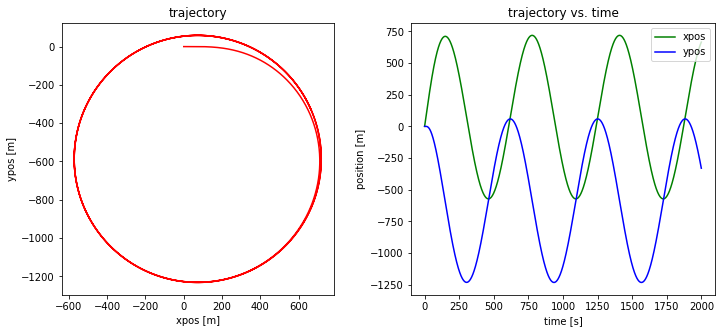

Turning diameter = 1290.6872412537025 [m]


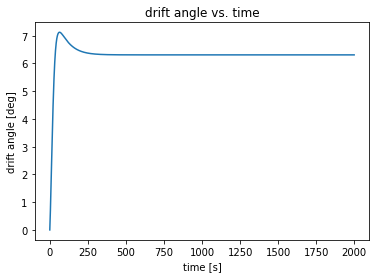

steady drift angle = 6.310449456407715 [deg]


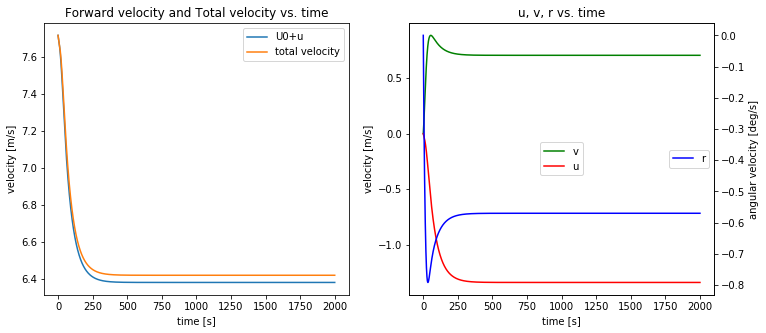

rudder angle = 20 [deg], turning diameter = 1290.6872412537025 [m], drift angle = 6.310449456407715 [deg]


In [4]:
def nonlinear_steady_turning(rudder_deg=20, gen_plot=False):
    U0 = 7.7175 # m/s = 15 knots
    ui = np.array([rudder_deg/180*np.pi, U0])
    state = np.array([0,0,0,0,0,0,ui[0],ui[1]])
    dt = 0.5
    time = np.arange(4000)*dt
    states = np.zeros((len(time), len(state)))
    states[0,:] = state
    for idx in range(1, len(time)):
        dState, ui = dX(state, ui)
        state += np.array(dState)*dt
        states[idx,:] = state
    
    # turning diameter
    turning_diameter = np.max(states[:,4]) - np.min(states[:,4])
    
    ## drift angle
    def cal_drift_angle():
        res = []
        for beta in states[:-1, 3] - np.arctan((states[1:,5] - states[:-1,5]) / (states[1:,4] - states[:-1,4])):
            while beta > np.pi:
                beta -= np.pi
            while beta < -np.pi:
                beta += np.pi
            res.append(-beta*180/np.pi)
        res.append(res[-1])
        return res
    beta = cal_drift_angle()
    drift_angle = np.mean(beta[-100:])

    
    if gen_plot:
        fig, axis = plt.subplots(1,2, figsize=(12,5))
        axis[0].plot(states[:,4], states[:,5], 'r')
        axis[0].set_title('trajectory')
        axis[0].set_aspect('equal', 'box')
        axis[0].set_xlabel('xpos [m]')
        axis[0].set_ylabel('ypos [m]')

        axis[1].plot(time, states[:,4], 'g', label='xpos')
        axis[1].plot(time, states[:,5], 'b', label='ypos')
        axis[1].set_title('trajectory vs. time')
        axis[1].set_xlabel('time [s]')
        axis[1].set_ylabel('position [m]')

        plt.legend(loc='upper right')
        plt.show()
        print(f'Turning diameter = {turning_diameter} [m]')
        
        plt.figure()
        plt.plot(time, beta)
        plt.title('drift angle vs. time')
        plt.xlabel('time [s]')
        plt.ylabel('drift angle [deg]')
        plt.show()
        print(f'steady drift angle = {drift_angle} [deg]')
        
        fig, axis = plt.subplots(1,2, figsize=(12,5))
        
        axis[0].plot(time, states[:,7] + states[:,0], label='U0+u')
        axis[0].plot(time, np.sqrt(np.power(states[:,7] + states[:,0],2) + np.power(states[:,1],2)), label='total velocity')
        axis[0].set_xlabel('time [s]')
        axis[0].set_ylabel('velocity [m/s]')
        axis[0].legend(loc='upper right')
        axis[0].set_title('Forward velocity and Total velocity vs. time')
        
        
        ax2 = axis[1].twinx()
        axis[1].plot(time, states[:,1], 'g-', label='v')
        axis[1].plot(time, states[:,0], 'r-', label='u')
        ax2.plot(time, states[:,2]/np.pi*180, 'b-', label='r')
        axis[1].legend(loc=10)

        axis[1].set_xlabel('time [s]')
        axis[1].set_ylabel('velocity [m/s]')
        ax2.set_ylabel('angular velocity [deg/s]')
        ax2.legend(loc=7)
        axis[1].set_title('u, v, r vs. time')


        plt.show()
    
    return turning_diameter, drift_angle
    

turning_diameter, drift_angle = nonlinear_steady_turning(20, True)
print(f'rudder angle = {20} [deg], turning diameter = {turning_diameter} [m], \
drift angle = {drift_angle} [deg]')

### Comparison

The nonlinear simulation result is compared against the linear model estimation in problem 2 for case-(20 degrees). The results are summarized below.

| model      | turning diameter D [meter] | drift angle [deg] |
| ---------- | -------------------------- | ----------------- |
| linear     | 239.03	                  | 4.92              |
| nonlinear  | 1290.69                    | 6.31              |

The linear model estimation is deviated from the nonlinear simulation result significantly. Hence linear manuvering model is not accurate when estimating steady turning performance at large rudder angles.

## Problem 4

A 20-20 degree zig-zag test was simulated. The first 648 [sec] simulation is ignored due to unsteady behavior. The test is performed until 5 cycles data is collected. The x-y trajectory and xy coordinates vs. time are plotted in the first row of the figure below. The rudder angle and the yaw angle in unit of degree are plotted against time in the second row of the figure below. Critical points evaluating the performance of vessel maneuvering are plotted as well.

Based on the simulation, 

* The overshoot yaw angle is 7.11 degree.
* The reach is 4.76 ship lengths.
* The overshoot width is 1.19 ship lengths.

Note that the reach is non-dimensionalized by the travel distance. The travel distance is estimated by numerically integrating the trajectory.

$$
S = \sum_{i=1}^{N-1}\sqrt{(x_i-x_{i-1})^2 + (y_i - y_{i-1})^2}
$$

truncate time = 648.0 [s]
overshoot yaw angle = 7.10542210356683 [deg]
reach = 113.5 [sec]
OR reach = 4.756674566640552 [ship lengths]
overshoot width = 192.07090892407572 [m]
OR overshoot width = 1.1935059275714641 [ship lengths]


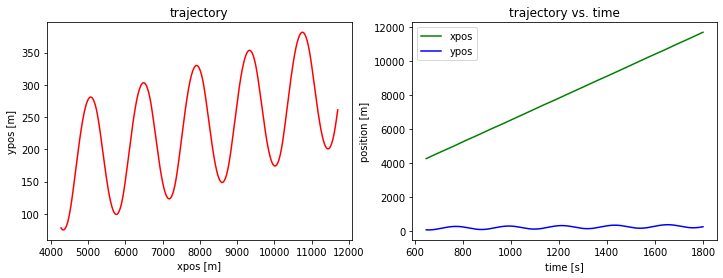

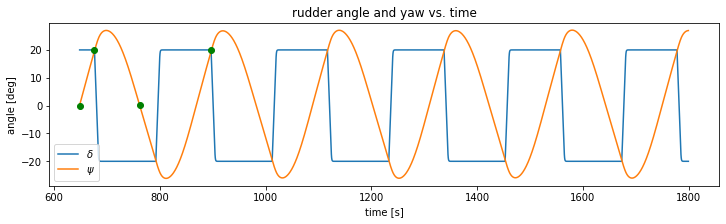

In [5]:
def zigzag(rudder_deg=20, gen_plot=False):
    U0 = 7.7175 # m/s = 15 knots
    L = 160.93 # meter
    ui = np.array([-rudder_deg/180*np.pi, U0])
    state = np.array([0,0,0,0,0,0,0,ui[1]])
    dt = 0.5
    time = np.arange(3600)*dt
    states = np.zeros((len(time), len(state)))
    states[0,:] = state
    for idx in range(1, len(time)):
        dState, ui = dX(state, ui)
        state += np.array(dState)*dt
        states[idx,:] = state
        if np.abs(state[3] + state[6]) < 1e-2:
            ui[0] = -ui[0]
    
    # truncate
    starttime = np.logical_and(np.abs(states[:,3]/np.pi*180) < 2e-1, time > 550)
    truncate_time = time[starttime][0]
    print(f'truncate time = {truncate_time} [s]')
    states = states[time > truncate_time, :]
    time = time[time > truncate_time]
    
    # calculate distance
    def cal_distance():
        distance = 0
        res = [distance]
        for i in range(1, len(time)):
            distance += np.sqrt((states[i,4]-states[i-1,4])**2 + (states[i,5]-states[i-1,5])**2)
            res.append(distance)
        return np.array(res)
    distance = cal_distance()

    # label
    first_exe_time = time[0]
    period_s = time[np.abs(states[:,3] + states[:,6]) < 1e-2][0]
    period_e = time[np.abs(states[:,3] + states[:,6]) < 1e-2][2]
    reach_time = time[np.abs(states[:,3]*180/np.pi) < 0.1][0]
    labelx = [time[0],period_s,period_e,reach_time]
    labely = [0, -states[time==period_s,6]/np.pi*180, -states[time==period_e,6]/np.pi*180, \
              states[time==reach_time,3]/np.pi*180]
    ymax = np.max(states[np.logical_and(time>600,time<800),5])
    
    # print result summary
    print(f'overshoot yaw angle = {(np.max(states[:,3])-np.max(-states[:,6]))/np.pi*180} [deg]')
    print(f'reach = {reach_time - first_exe_time} [sec]')
    print(f'OR reach = {distance[time==reach_time][0]/L} [ship lengths]')
#     print(f'period = {period_e-period_s} [sec]')
#     print(f'OR period = {(distance[time==period_e][0] - distance[time==period_s][0])/L} [ship lengths]')
    print(f'overshoot width = {ymax - states[time==period_s,5][0]} [m]')
    print(f'OR overshoot width = {(ymax - states[time==period_s,5][0])/L} [ship lengths]')
    
    if gen_plot:
        fig, axis = plt.subplots(1,2, figsize=(12,4))
        axis[0].plot(states[:,4], states[:,5], 'r')
        axis[0].set_title('trajectory')
        axis[0].set_xlabel('xpos [m]')
        axis[0].set_ylabel('ypos [m]')

        axis[1].plot(time, states[:,4], 'g', label='xpos')
        axis[1].plot(time, states[:,5], 'b', label='ypos')
        axis[1].set_title('trajectory vs. time')
        axis[1].set_xlabel('time [s]')
        axis[1].set_ylabel('position [m]')
        axis[1].legend(loc='upper left')
        plt.show()
        
        plt.figure(figsize=(12,3))
        plt.plot(time, -states[:,6]/np.pi*180, label=r'$\delta$')
        plt.plot(time, states[:,3]/np.pi*180, label=r'$\psi$')
        plt.plot(labelx,labely, 'go')
        plt.title(r'rudder angle and yaw vs. time')
        plt.xlabel('time [s]')
        plt.ylabel('angle [deg]')
        plt.legend(loc='lower left')
        plt.show()
        

zigzag(20, True)